-> K-PDF generator
- for multiple files

In [2]:
# read in libraries
import sys, os
import netCDF4
import scipy.io, numpy
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import interpolate

In [3]:
directory = '/Users/evenhou/Downloads/armdata'

In [4]:
xnew = np.linspace(0, 1.3, 30) # K0
df_k = pd.DataFrame(columns=['dia', 'K0', 'dNdK'])
print(df_k)

for subdir, dirs, files in os.walk(directory):
    for file in files:
        filename = subdir + os.sep + file
        if ('sgpaoshtdmaE13.b1.20221208' in filename):
        
# =============== FOR EACH FILE ===============
# get dimensions of time and bins
            ds = netCDF4.Dataset(filename)
            s1 = str(ds.dimensions['time'])
            s2 = str(ds.dimensions['bin'])
            # print(s)
            x = -3
            if (s1[x-1:x+1] != '='):
                dim_time = int(s1[x:])
            else:
                dim_time = int(s1[x-1:])
            if (s2[x-1:x+1] != '='):
                dim_bin = int(s2[x:])
            else:
                dim_bin = int(s2[x-1:])
            # print(dim_time, dim_bin)

# CHANGE HERE: define arrays
            time = np.zeros(dim_time)
            dry_dia = np.zeros(dim_time)
            kappa = np.zeros((dim_time, dim_bin))
            k_bound = np.zeros((dim_time, dim_bin,2))
            conc = np.zeros((dim_time, dim_bin))
            
# CHANGE HERE: read data into arrays
            ncf = scipy.io.netcdf_file(filename, mmap=False)
            date = int(filename[-18:-10]) # read i.e. 20210427
            time[:] = ncf.variables["time"].data/3600 # hr
            dry_dia[:] = ncf.variables["dry_diameter_setting"].data # nm
            for i_time in range(dim_time):
                kappa[i_time, :] = ncf.variables['kappa'][i_time, :]
                k_bound[i_time, :, :] = ncf.variables['kappa_bounds'][i_time, :, :]
                conc[i_time,:] = ncf.variables['aerosol_concentration'][i_time, :] # dN, unit: 1/cm^3
            # print(dry_dia)
            # print(k_bound)
            # print(date)

# calculations
            dK = np.zeros((dim_time,dim_bin))
            for i_time in range(dim_time):
                dK[i_time, :] = k_bound[i_time, :, 1] -  k_bound[i_time, :, 0]
            conc_norm0 = np.zeros((dim_time,dim_bin)) # dN/dK
            for i_time in range(dim_time):
                conc_norm0[i_time, :] = conc[i_time, :]/dK[i_time, :]
            
# use pandas to manipulate data
            d = {'dry_dia': dry_dia, 'time':time, 'date':date}
            df = pd.DataFrame(data = d)
            #print(df)
    
            df_conc = pd.DataFrame(conc)
            # print(df_conc)
            N_tot = df_conc.sum(axis=1)# N_tot (series) for each scan
            N_tot.name = "N_tot"
            #print(N_tot) 
            #print(type(N_tot)) # Series
            
            df = df.join(N_tot)
            # print(df)
            Ntot = N_tot.to_numpy()
            conc_norm = np.zeros((dim_time,dim_bin))
            for i_time in range(dim_time):
                conc_norm[i_time, :] = conc_norm0[i_time, :]/Ntot[i_time]
            # print(conc_norm)

            dNdK = np.zeros((dim_time,30))
            for i_time in range(dim_time):
            # i_time = 1
                # dia = dry_dia[i_time]
                x = kappa[i_time,:] # one scan:kappa
                y = conc_norm[i_time,:] # one scan: c(k)
                f = interpolate.interp1d(x,y,fill_value="extrapolate")
                ynew = f(xnew)
                dNdK[i_time,:] = ynew
            dia = np.repeat(dry_dia, 30) # for one scan
            x_flat = np.tile(xnew, dim_time) # for different bin
            # print(x_flat)
            y_flat = dNdK.ravel()
            # print(y_flat.shape)

            temp_df = pd.DataFrame({'dia': dia,'K0': x_flat,'dNdK': y_flat})
            df_k = pd.concat([df_k, temp_df], ignore_index=True)
            # print(df_k)
print(df_k)

Empty DataFrame
Columns: [dia, K0, dNdK]
Index: []
        dia        K0      dNdK
0     200.0  0.000000  0.031944
1     200.0  0.044828  0.452181
2     200.0  0.089655  0.842635
3     200.0  0.134483  1.063116
4     200.0  0.179310  1.146557
...     ...       ...       ...
4645  150.0  1.120690  0.000000
4646  150.0  1.165517  0.000000
4647  150.0  1.210345  0.000000
4648  150.0  1.255172  0.000000
4649  150.0  1.300000  0.000000

[4650 rows x 3 columns]


/var/folders/n8/bjc7cpvs3hnd3g97l3ky6q4w0000gn/T/ipykernel_14732/4135992585.py:72: RuntimeWarning: invalid value encountered in divide
  conc_norm[i_time, :] = conc_norm0[i_time, :]/Ntot[i_time]
/var/folders/n8/bjc7cpvs3hnd3g97l3ky6q4w0000gn/T/ipykernel_14732/4135992585.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_k = pd.concat([df_k, temp_df], ignore_index=True)


In [5]:
# df_k100 = df_k[df_k["dia"] == 100]
# dNdK100 = df_k100['dNdK'].to_numpy()
# d_scan = int(df_k100.shape[0]/30)
# dNdK100_matrix = dNdK100.reshape(d_scan, 30)
# # print(dNdK100_matrix)
# # print(np.isnan(dNdK100_matrix).any())
# dNdK100_matrix = np.nan_to_num(dNdK100_matrix)
# # print(dNdK100_matrix.shape)
# avg100 = np.mean(dNdK100_matrix, axis=0)

In [6]:
def k_size(df_k,size):
    if size == 50:
        df_k_i = df_k[df_k["dia"] == 50]  
    elif size == 100:
        df_k_i = df_k[df_k["dia"] == 100]
    elif size == 150:
        df_k_i = df_k[df_k["dia"] == 150]
    elif size == 200:
        df_k_i = df_k[df_k["dia"] == 200]  
    elif size == 250:
        df_k_i = df_k[df_k["dia"] == 250]  

    dNdK_i = df_k_i['dNdK'].to_numpy()
    d_scan = int(df_k_i.shape[0]/30)
    dNdK_i_matrix = dNdK_i.reshape(d_scan, 30)
    # print(np.isnan(dNdK100_matrix).any()) 
    dNdK_i_matrix = np.nan_to_num(dNdK_i_matrix) # could result in inaccuracy -> should remove this data when calculating the average
    # print(dNdK100_matrix.shape)
    avg_i = np.mean(dNdK_i_matrix, axis=0)

    return df_k_i.K0, df_k_i.dNdK, avg_i

In [7]:
x50, y50, avg50 = k_size(df_k,50)
x100, y100, avg100 = k_size(df_k,100)
x150, y150, avg150 = k_size(df_k,150)
x200, y200, avg200 = k_size(df_k,200)
x250, y250, avg250 = k_size(df_k,250)


In [8]:
x_values = [x50,x100,x150,x200,x250]
y_values = [y50,y100,y150,y200,y250]
avg_values = [avg50,avg100,avg150,avg200,avg250]


PLOT JUST FOR ONE DIA:

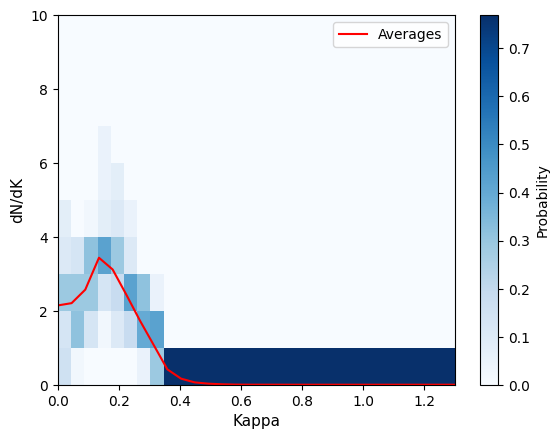

In [9]:
# Plotting the 2D histogram
fig, ax = plt.subplots()
h, xedges, yedges, image = ax.hist2d(
    x100,  # Repeat xnew for each row in ynew
    y100,    # Flatten ynew to a 1D array
    bins=(30, 10),     # Specify bins for x and y
    range=[[0, 1.3], [0, 10]],  # Define the range of x and y
    cmap='Blues',    # Colormap
    density=True       # Normalize to show probability densities
)

# Overlay the column averages as a line plot
ax.plot(xnew, avg100, 'r-', label='Averages')

# Adding the colorbar
cbar = plt.colorbar(image, ax=ax)
cbar.set_label('Probability')  # Label the colorbar

# Customizing the plot
ax.set_xlabel('Kappa',fontsize = 11)
ax.set_ylabel('dN/dK',fontsize = 11)
# ax.set_title('Κ-PDF for 100 nm aerosols in 2022 winter (Dec, Jan, Feb)')
ax.legend()

# Display the plot
plt.show()

PLOTS FOR ALL DIA:

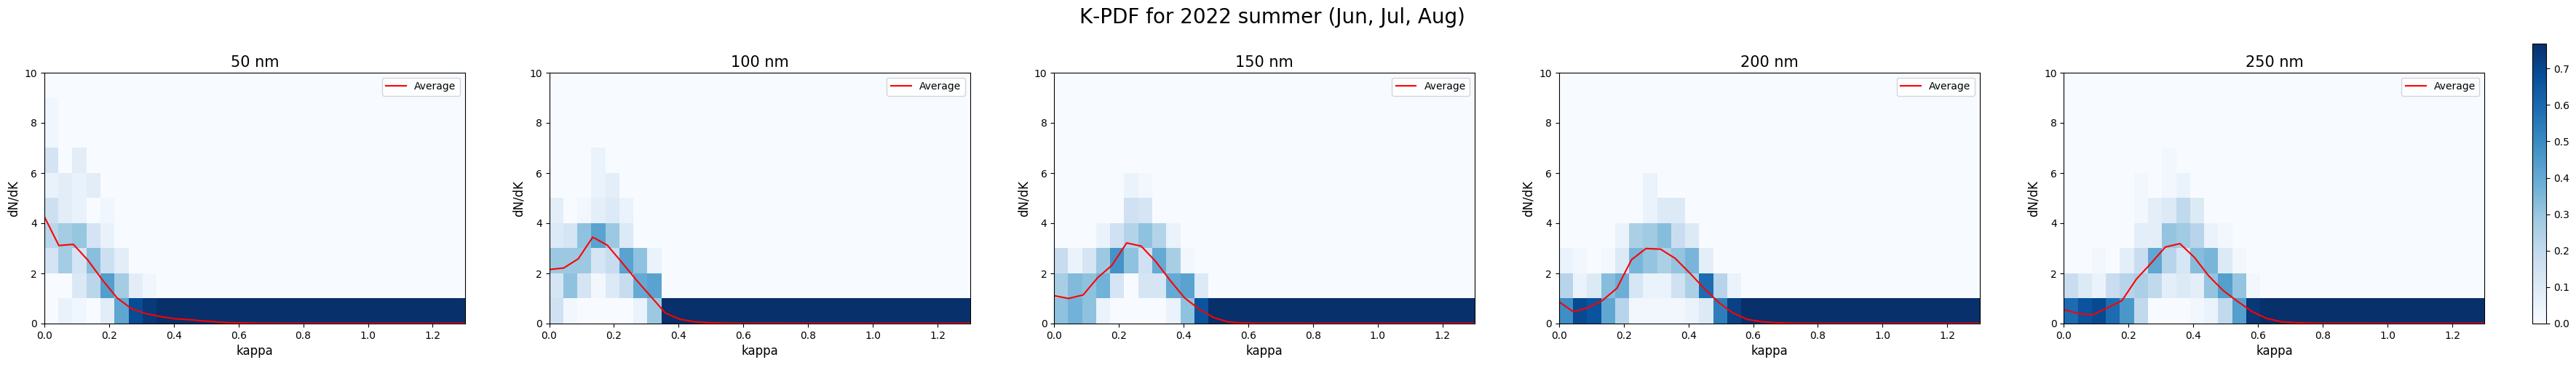

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(45, 5))
# h, xedges, yedges, image = ax.hist2d(x, y, bins=(30, 10), range=[[0, 1.3], [0, 10]], cmap='viridis', density=True)
titles = ['50 nm', '100 nm', '150 nm', '200 nm', '250 nm']
images = []
for ax, x, y, avg,title in zip(axes, x_values, y_values, avg_values, titles):
    # Flatten y and repeat x for each element in y
    image = ax.hist2d(
        x,
        y,
        bins=(30, 10),
        range=[[0, 1.3], [0, 10]],
        cmap='Blues',
        density=True
    )[3]
    images.append(image)
    ax.set_title(title, fontsize=15)
    ax.set_xlabel('kappa', fontsize=12)
    ax.set_ylabel('dN/dK', fontsize=12)
    # Plotting the average line
    ax.plot(xnew, avg, 'r-', label='Average')
    ax.legend()

# Create a single colorbar for all subplots
fig.colorbar(images[0], ax=axes, orientation='vertical', fraction=0.02, pad=0.05)

# Add a main title to the figure
fig.suptitle('Κ-PDF for 2022 summer (Jun, Jul, Aug)', fontsize=20, y=0.98)
# plt.tight_layout()
plt.subplots_adjust(top=0.8, right=0.87) 

# Display the plot
plt.show()